# Influence of salt intake behavior to blood pressure
## STATS 506 group project
### Author: Xinjun Li

This is a report generated by jupyter notebook for the group project of STATS 506 in University of Michigan.

Our project aims to answer the following question:

>**Is salt intake associated with blood pressure?**
**If so, to what extent is that relationship mediated or moderated by age or waist size?**

We will use [NHANES](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx) data in analysis.

Required software and packages to run the code are as follows:
* Python3 
* os
* pandas
* statsmodels
* patsy
* matplotlib

In [1]:
# Import packages
import os
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import patsy
from statsmodels.api import OLS
from statsmodels.stats.mediation import Mediation
import matplotlib.pyplot as plt

In [2]:
# Set working directory
os.chdir('D:/学习/密歇根/STAT506/Group project/stats506/')

# read data
demo = pd.read_excel("RawData/Demographics_15_16.xlsx")
BMI = pd.read_excel("RawData/Body_measures_2015_16.xlsx")
bp = pd.read_excel('RawData/Blood_Pressure_2015_16.xlsx')
nutr = pd.read_excel("RawData/Dietary_nutrients_firstday_2015_16.xlsx")

## Data cleaning

We need first clean the raw data and join different dataset.

In [3]:
# select useful columns
# ! Note: we need to drop values '9' or '99' which represent "don't know"
demo=demo.set_index('SEQN'
                    ).filter(items=['RIDAGEYR']  # 'RIAGENDR','RIDRETH3'
                    ).dropna()
# demo[['RIAGENDR','RIDRETH3']]=demo[['RIAGENDR','RIDRETH3']].astype('category')
BMI=BMI.set_index('SEQN'
                  ).filter(items=['BMXWAIST']   # ,'BMXWT','BMXHT'
                  ).dropna()
nutr=nutr.set_index('SEQN'
                    ).filter(items=['DBD100']  #,'DBQ095Z','DRQSPREP'
                    ).dropna(
                    ).query('DBD100 != 9'
                    ).astype('category')

# Calculate mean of blood pressure
bp=bp.set_index('SEQN'
                ).filter(regex='(BPXSY*)|(BPXDI*)')
bp=bp.assign(SY=bp.filter(regex='BPXSY*').mean(axis=1, skipna = True),
             DI=bp.filter(regex='BPXDI*').mean(axis=1, skipna = True)
             ).filter(items=['SY','DI']).dropna()

# Merge all data set
df=bp.join(demo,how='inner').join(BMI,how='inner').join(nutr,how='inner')

Take a look at the data we are about to work on.

In [4]:
# Show data summary of numeric variables
df.describe()

,SY,DI,RIDAGEYR,BMXWAIST
count,4670.000000,4670.000000,4670.000000,4670.000000
mean,119.510921,66.050393,38.107281,93.630557
std,17.292694,13.378804,21.598139,19.019918
min,74.000000,0.000000,8.000000,46.300000
25%,107.333333,58.666667,18.000000,79.700000
50%,116.666667,66.666667,35.000000,93.000000
75%,128.000000,74.666667,56.000000,105.900000
max,206.666667,124.000000,80.000000,171.600000


In [5]:
# Show data summary of categorical variables
df.describe(include='category')

,DBD100
count,4670.0
unique,3.0
top,1.0
freq,2444.0


Generate plots show the relationship between salt intake behaviors and blood presure.

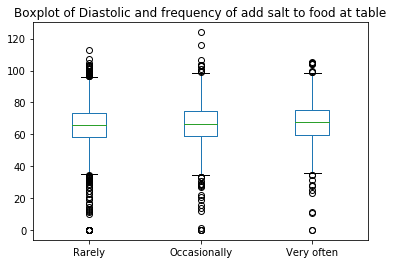

In [6]:
# plot Diastolic and salt intakes
DI_salt=df[['DBD100','DI']
            ].pivot(columns='DBD100', values='DI'
            )
DI_salt.columns=["Rarely","Occasionally","Very often"]
DI_salt.boxplot(grid=False)
plt.title("Boxplot of Diastolic and frequency of add salt to food at table")
plt.suptitle("")
plt.show()

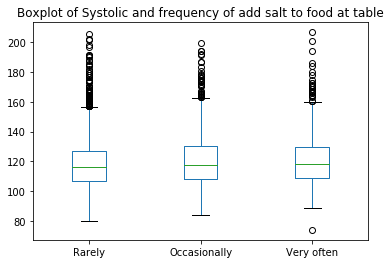

In [7]:
# plot Systolic and salt intakes
SY_salt=df[['DBD100','SY']
            ].pivot(columns='DBD100', values='SY'
            )
SY_salt.columns=["Rarely","Occasionally","Very often"]
SY_salt.boxplot(grid=False)
plt.title("Boxplot of Systolic and frequency of add salt to food at table")
plt.suptitle("")
plt.show()

## Fit OLS

Now fit the ordinary least square to the data.
The models used are:
`DI ~ DBD100` and `SY ~ DBD100`

### Diastolic result

In [8]:
# fit ols to Diastolic measurements
ols_DI=ols('DI~DBD100',data=df).fit()
# Print the summary
ols_DI.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     DI   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.993
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           0.000343
Time:                        12:15:13   Log-Likelihood:                -18730.
No. Observations:                4670   AIC:                         3.747e+04
Df Residuals:                    4667   BIC:                         3.749e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        65.4003      0.270    242.026      0.000      64.871      65.930
DBD100[T.2.0]     0.9326      0.449      2.077      0.038       0.052       1.813
DBD100[T.3.0]     2.0782      0.535      3.886      0.000       1.030       3.127
==============================================================================
Omnibus:                      524.110   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1560.469
Skew:                          -0.594   Prob(JB):                         0.00
Kurtosis:                       5.570   Cond. No.                         3.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
anova_lm(ols_DI)

,df,sum_sq,mean_sq,F,PR(>F)
DBD100,2.0,2852.76590,1426.382950,7.992829,0.000343
Residual,4667.0,832862.70838,178.457833,NaN,NaN


### Systolic result

In [10]:
# fit ols to Systolic measurements
ols_SY=ols('SY~DBD100',data=df).fit()
# Print the summary
ols_SY.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SY   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     8.841
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           0.000147
Time:                        12:15:13   Log-Likelihood:                -19928.
No. Observations:                4670   AIC:                         3.986e+04
Df Residuals:                    4667   BIC:                         3.988e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       118.5461      0.349    339.471      0.000     117.861     119.231
DBD100[T.2.0]     1.6571      0.580      2.856      0.004       0.520       2.795
DBD100[T.3.0]     2.6321      0.691      3.809      0.000       1.277       3.987
==============================================================================
Omnibus:                      835.290   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1634.915
Skew:                           1.084   Prob(JB):                         0.00
Kurtosis:                       4.923   Cond. No.                         3.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
anova_lm(ols_SY)

,df,sum_sq,mean_sq,F,PR(>F)
DBD100,2.0,5.269709e+03,2634.854509,8.840718,0.000147
Residual,4667.0,1.390935e+06,298.036262,NaN,NaN


From the above results, we know that both models are significant and every coefficients are significant(at the level of 95%).

## Moderation effect of waist size


First, add two columns recording a standiviation above and below  of waist size.

In [12]:
df['waist_sd'] = df['BMXWAIST'].std()
df['waist_up']=df['BMXWAIST']+df['waist_sd']
df['waist_down']=df['BMXWAIST']-df['waist_sd']

### Diastolic result

Fit model: `DI ~ DBD100 + BMXWAIST + DBD100 * BMXWAIST`

In [13]:
moderation_DI = ols('DI ~ DBD100 + BMXWAIST + DBD100 * BMXWAIST', data=df).fit()
moderation_DI.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     DI   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     92.35
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           5.66e-93
Time:                        12:15:13   Log-Likelihood:                -18518.
No. Observations:                4670   AIC:                         3.705e+04
Df Residuals:                    4664   BIC:                         3.709e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 45.2378      1.273     35.545      0.000      42.743      47.733
DBD100[T.2.0]              2.5683      2.137      1.202      0.229      -1.621       6.757
DBD100[T.3.0]              3.7644      2.720      1.384      0.166      -1.567       9.096
BMXWAIST                   0.2182      0.013     16.179      0.000       0.192       0.245
DBD100[T.2.0]:BMXWAIST    -0.0214      0.022     -0.955      0.339      -0.065       0.023
DBD100[T.3.0]:BMXWAIST    -0.0266      0.028     -0.953      0.341      -0.081       0.028
==============================================================================
Omnibus:                      642.737   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2183.342
Skew:                          -0.685   Prob(JB):                         0.00
Kurtosis:                       6.057   Cond. No.                     1.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
anova_lm(moderation_DI)

,df,sum_sq,mean_sq,F,PR(>F)
DBD100,2.0,2852.765900,1426.382950,8.748537,1.613124e-04
BMXWAIST,1.0,72202.692290,72202.692290,442.845941,5.372836e-94
DBD100:BMXWAIST,2.0,229.976156,114.988078,0.705265,4.940305e-01
Residual,4664.0,760430.039934,163.042461,NaN,NaN


In [15]:
# one standard deviation above mean
moderation_DI_up = ols('DI ~ DBD100 + waist_up + DBD100 * waist_up', data=df).fit()
moderation_DI_up.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     DI   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     92.35
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           5.66e-93
Time:                        12:15:13   Log-Likelihood:                -18518.
No. Observations:                4670   AIC:                         3.705e+04
Df Residuals:                    4664   BIC:                         3.709e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 41.0870      1.525     26.946      0.000      38.098      44.076
DBD100[T.2.0]              2.9751      2.555      1.164      0.244      -2.035       7.985
DBD100[T.3.0]              4.2712      3.244      1.317      0.188      -2.088      10.630
waist_up                   0.2182      0.013     16.179      0.000       0.192       0.245
DBD100[T.2.0]:waist_up    -0.0214      0.022     -0.955      0.339      -0.065       0.023
DBD100[T.3.0]:waist_up    -0.0266      0.028     -0.953      0.341      -0.081       0.028
==============================================================================
Omnibus:                      642.737   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2183.342
Skew:                          -0.685   Prob(JB):                         0.00
Kurtosis:                       6.057   Cond. No.                     2.32e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
# one standard deviation below mean
moderation_DI_down = ols('DI ~ DBD100 + waist_down + DBD100 * waist_down', data=df).fit()
moderation_DI_down.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     DI   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     92.35
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           5.66e-93
Time:                        12:15:14   Log-Likelihood:                -18518.
No. Observations:                4670   AIC:                         3.705e+04
Df Residuals:                    4664   BIC:                         3.709e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   49.3885      1.023     48.287      0.000      47.383      51.394
DBD100[T.2.0]                2.1615      1.722      1.255      0.209      -1.214       5.537
DBD100[T.3.0]                3.2576      2.200      1.481      0.139      -1.055       7.570
waist_down                   0.2182      0.013     16.179      0.000       0.192       0.245
DBD100[T.2.0]:waist_down    -0.0214      0.022     -0.955      0.339      -0.065       0.023
DBD100[T.3.0]:waist_down    -0.0266      0.028     -0.953      0.341      -0.081       0.028
==============================================================================
Omnibus:                      642.737   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2183.342
Skew:                          -0.685   Prob(JB):                         0.00
Kurtosis:                       6.057   Cond. No.                     1.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For the models above, coefficients for the interation terms and salt intake itself are not significant(at level of 95%).
There are not moderation effect of waist size on salt intake and diastole.

### Systolic result

Fit model: `SY ~ DBD100 + BMXWAIST + DBD100 * BMXWAIST`

In [17]:
moderation_SY = ols('SY ~ DBD100 + BMXWAIST + DBD100 * BMXWAIST', data=df).fit()
moderation_SY.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SY   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     199.6
Date:                Thu, 05 Dec 2019   Prob (F-statistic):          2.71e-193
Time:                        12:15:14   Log-Likelihood:                -19484.
No. Observations:                4670   AIC:                         3.898e+04
Df Residuals:                    4664   BIC:                         3.902e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 83.3170      1.565     53.231      0.000      80.248      86.386
DBD100[T.2.0]              1.6470      2.628      0.627      0.531      -3.505       6.799
DBD100[T.3.0]              1.3457      3.345      0.402      0.687      -5.211       7.903
BMXWAIST                   0.3813      0.017     22.986      0.000       0.349       0.414
DBD100[T.2.0]:BMXWAIST    -0.0069      0.028     -0.250      0.802      -0.061       0.047
DBD100[T.3.0]:BMXWAIST    -0.0027      0.034     -0.078      0.938      -0.070       0.065
==============================================================================
Omnibus:                     1183.493   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3393.681
Skew:                           1.320   Prob(JB):                         0.00
Kurtosis:                       6.236   Cond. No.                     1.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
anova_lm(moderation_SY)

,df,sum_sq,mean_sq,F,PR(>F)
DBD100,2.0,5.269709e+03,2634.854509,10.684907,2.345321e-05
BMXWAIST,1.0,2.407964e+05,240796.362719,976.481519,8.385065e-195
DBD100:BMXWAIST,2.0,1.548005e+01,7.740026,0.031387,9.691002e-01
Residual,4664.0,1.150123e+06,246.595924,NaN,NaN


In [19]:
# one standard deviation above mean
moderation_SY_up = ols('SY ~ DBD100 + waist_up + DBD100 * waist_up', data=df).fit()
moderation_SY_up.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SY   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     199.6
Date:                Thu, 05 Dec 2019   Prob (F-statistic):          2.71e-193
Time:                        12:15:14   Log-Likelihood:                -19484.
No. Observations:                4670   AIC:                         3.898e+04
Df Residuals:                    4664   BIC:                         3.902e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 76.0645      1.875     40.563      0.000      72.388      79.741
DBD100[T.2.0]              1.7782      3.143      0.566      0.572      -4.383       7.939
DBD100[T.3.0]              1.3965      3.989      0.350      0.726      -6.424       9.217
waist_up                   0.3813      0.017     22.986      0.000       0.349       0.414
DBD100[T.2.0]:waist_up    -0.0069      0.028     -0.250      0.802      -0.061       0.047
DBD100[T.3.0]:waist_up    -0.0027      0.034     -0.078      0.938      -0.070       0.065
==============================================================================
Omnibus:                     1183.493   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3393.681
Skew:                           1.320   Prob(JB):                         0.00
Kurtosis:                       6.236   Cond. No.                     2.32e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
# one standard deviation below mean
moderation_SY_down = ols('SY ~ DBD100 + waist_down + DBD100 * waist_down', data=df).fit()
moderation_SY_down.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SY   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     199.6
Date:                Thu, 05 Dec 2019   Prob (F-statistic):          2.71e-193
Time:                        12:15:14   Log-Likelihood:                -19484.
No. Observations:                4670   AIC:                         3.898e+04
Df Residuals:                    4664   BIC:                         3.902e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   90.5694      1.258     72.002      0.000      88.103      93.035
DBD100[T.2.0]                1.5158      2.118      0.716      0.474      -2.636       5.667
DBD100[T.3.0]                1.2949      2.705      0.479      0.632      -4.008       6.598
waist_down                   0.3813      0.017     22.986      0.000       0.349       0.414
DBD100[T.2.0]:waist_down    -0.0069      0.028     -0.250      0.802      -0.061       0.047
DBD100[T.3.0]:waist_down    -0.0027      0.034     -0.078      0.938      -0.070       0.065
==============================================================================
Omnibus:                     1183.493   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3393.681
Skew:                           1.320   Prob(JB):                         0.00
Kurtosis:                       6.236   Cond. No.                     1.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For the models above, coefficients for the interation terms and salt intake itself are not significant(at level of 95%). 
There are not moderation effect of waist size on salt intake and diastole.

## Mediation effect of age

Fit model: `RIDAGEYR ~ DBD100` to see if there are relationships between age and salt intake

In [21]:
# test if there is relationship between age and salt intake.
age_D = ols('RIDAGEYR ~ DBD100', data=df).fit()
age_D.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               RIDAGEYR   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     20.96
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           8.67e-10
Time:                        12:15:14   Log-Likelihood:                -20954.
No. Observations:                4670   AIC:                         4.191e+04
Df Residuals:                    4667   BIC:                         4.193e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        36.2901      0.435     83.420      0.000      35.437      37.143
DBD100[T.2.0]     2.9959      0.723      4.145      0.000       1.579       4.413
DBD100[T.3.0]     5.1646      0.861      5.999      0.000       3.477       6.852
==============================================================================
Omnibus:                     1880.486   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.994
Skew:                           0.347   Prob(JB):                     1.63e-71
Kurtosis:                       1.908   Cond. No.                         3.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model is significant. There are relationships between age and salt intake behavior.

### Diastolic result

Fit model: `DI ~ DBD100 + RIDAGEYR`.

In [22]:
mediation_DI = ols('DI ~ DBD100 + RIDAGEYR', data=df).fit()
mediation_DI.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     DI   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     121.6
Date:                Thu, 05 Dec 2019   Prob (F-statistic):           7.67e-76
Time:                        12:15:14   Log-Likelihood:                -18563.
No. Observations:                4670   AIC:                         3.713e+04
Df Residuals:                    4666   BIC:                         3.716e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        59.4642      0.411    144.512      0.000      58.657      60.271
DBD100[T.2.0]     0.4425      0.434      1.020      0.308      -0.408       1.293
DBD100[T.3.0]     1.2334      0.518      2.381      0.017       0.218       2.249
RIDAGEYR          0.1636      0.009     18.646      0.000       0.146       0.181
==============================================================================
Omnibus:                      724.710   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2672.320
Skew:                          -0.747   Prob(JB):                         0.00
Kurtosis:                       6.391   Cond. No.                         136.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model is significant. Age might be a mediator between salt intake and diastolic.

In [23]:
# Create design matrix
DI,model_mat = patsy.dmatrices("DI ~ DBD100 + RIDAGEYR", data=df)
df_med_DI=pd.DataFrame(model_mat).iloc[:,1:]
df_med_DI.columns=['DBD2','DBD3','RIDAGEYR']
df_med_DI['DI']=DI

# origin model and mediator model
med_model_DI=OLS.from_formula('DI ~ RIDAGEYR+DBD2+DBD3', data=df_med_DI)
mediator_DI=OLS.from_formula('RIDAGEYR ~ DBD2+DBD3', data=df_med_DI)

# origin model and mediator model
med_DI = Mediation(med_model_DI,mediator_DI,['DBD2','DBD3'],'RIDAGEYR').fit()
med_DI.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),1.336201,0.894425,1.810091,0.000
ACME (treated),1.336201,0.894425,1.810091,0.000
ADE (control),1.692829,0.107259,3.290577,0.038
ADE (treated),1.692829,0.107259,3.290577,0.038
Total effect,3.029030,1.396428,4.608381,0.000
Prop. mediated (control),0.438871,0.269666,0.920362,0.000
Prop. mediated (treated),0.438871,0.269666,0.920362,0.000
ACME (average),1.336201,0.894425,1.810091,0.000
ADE (average),1.692829,0.107259,3.290577,0.038
Prop. mediated (average),0.438871,0.269666,0.920362,0.000


All the mediation effect(ACME) are significant(at level of 95%).
Which means that age is a mediator between salt intake and diastolic.

### Systolic result

Fit model: `SY ~ DBD100 + RIDAGEYR`.

In [24]:
mediation_SY = ols('SY ~ DBD100 + RIDAGEYR', data=df).fit()
mediation_SY.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SY   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     753.2
Date:                Thu, 05 Dec 2019   Prob (F-statistic):               0.00
Time:                        12:16:57   Log-Likelihood:                -19015.
No. Observations:                4670   AIC:                         3.804e+04
Df Residuals:                    4666   BIC:                         3.806e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       101.9719      0.453    224.951      0.000     101.083     102.861
DBD100[T.2.0]     0.2888      0.478      0.604      0.546      -0.648       1.226
DBD100[T.3.0]     0.2734      0.571      0.479      0.632      -0.845       1.392
RIDAGEYR          0.4567      0.010     47.259      0.000       0.438       0.476
==============================================================================
Omnibus:                      587.593   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1253.258
Skew:                           0.767   Prob(JB):                    7.22e-273
Kurtosis:                       5.022   Cond. No.                         136.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model is significant. 
Even thought the coefficients of salt intake is not significant(at level of 95%).
Age might be a mediator between salt intake and systolic.

In [25]:
# Create design matrix
SY,model_mat = patsy.dmatrices("SY ~ DBD100 + RIDAGEYR", data=df)
df_med_SY=pd.DataFrame(model_mat).iloc[:,1:]
df_med_SY.columns=['DBD2','DBD3','RIDAGEYR']
df_med_SY['SY']=SY

# origin model and mediator model
med_model_SY=OLS.from_formula('SY ~ RIDAGEYR+DBD2+DBD3', data=df_med_SY)
mediator_SY=OLS.from_formula('RIDAGEYR ~ DBD2+DBD3', data=df_med_SY)

# origin model and mediator model
med_SY = Mediation(med_model_SY,mediator_SY,['DBD2','DBD3'],'RIDAGEYR').fit()
med_SY.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),3.737113,2.471780,5.024574,0.000
ACME (treated),3.737113,2.471780,5.024574,0.000
ADE (control),0.563925,-1.081074,2.157202,0.514
ADE (treated),0.563925,-1.081074,2.157202,0.514
Total effect,4.301039,2.189444,6.329029,0.000
Prop. mediated (control),0.870716,0.616533,1.373339,0.000
Prop. mediated (treated),0.870716,0.616533,1.373339,0.000
ACME (average),3.737113,2.471780,5.024574,0.000
ADE (average),0.563925,-1.081074,2.157202,0.514
Prop. mediated (average),0.870716,0.616533,1.373339,0.000


All the mediation effect(ACME) are significant.
Which means that age is a mediator between salt intake and systolic.